[ref](https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import OneHotEncoder
from sklearn.gaussian_process import GaussianProcessRegressor, kernels

In [2]:
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data

from torch.utils.data.sampler import SubsetRandomSampler

In [3]:
# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
np.random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


In [4]:
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
ngpu=0

In [5]:
df = pd.read_csv("datasets/health_insurance.csv")


In [6]:
df.dtypes

age           int64
sex          object
bmi         float64
children      int64
smoker       object
region       object
charges     float64
dtype: object

In [7]:
# download the dataset from: https://www.kaggle.com/datasets/teertha/ushealthinsurancedataset
df = pd.read_csv("datasets/health_insurance.csv")

df[df.select_dtypes(['float64','int64']).columns] = (df[df.select_dtypes(['float64','int64']).columns] - df[df.select_dtypes(['float64','int64']).columns].mean()) / df[df.select_dtypes(['float64','int64']).columns].std()

# df = df.sample(n=10**5, random_state=43) # no need to sample when the dataset is so small


for feat in df.select_dtypes(['category']).columns:
    df[feat] = df[feat].values.codes

for feat in df.columns:
    num_new_feats = len(df[feat].unique())
    if df[feat].dtype != "float64" and df[feat].dtype!='int64':
        new_feats = OneHotEncoder(sparse=False).fit_transform(df[feat].values.reshape(-1,1))
        for idx in range(num_new_feats):
            df[f"{feat}_{idx}"] = new_feats[:,idx]
            df[f"{feat}_{idx}"] = df[f"{feat}_{idx}"].astype("float")
        del df[feat]


x = df.drop(columns="charges").values
y = df["charges"].values
print(x.shape, y.shape)

(1338, 11) (1338,)


In [8]:
n_samples = x.shape[0] # 10**5
n_feats = x.shape[1] # 10

In [9]:
# x = np.random.randn(n_samples, n_feats)
# w = np.random.randn(n_feats)
# y = x.dot(w) + 2*np.random.randn(n_samples)

In [10]:
y.min(), y.max()

(-1.0031822537315642, 4.170103954308559)

### Simple Linear Regression check

In [11]:
from sklearn.linear_model import LinearRegression

reg = LinearRegression().fit(x, y)
reg.coef_

array([ 0.29800316,  0.17080621,  0.04733377,  0.00542173, -0.00542173,
       -0.98466195,  0.98466195,  0.04847305,  0.0193266 , -0.03699524,
       -0.03080441])

In [12]:
reg.score(x, y), (1-reg.score(x, y))*y.var()

(0.7509130345985207, 0.24890080175020768)

# Regress GAN

### Define ANN Architecture

In [13]:
# Batch size during training
batch_size = 64

# Size of z latent vector (i.e. size of generator input)
nz = 5

# Number of training epochs
num_epochs = 500

# Learning rate for optimizers
lr = 0.0002
# lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# width of the network
network_width = 128

In [14]:
# create train and test indices
train, test = train_test_split(list(range(x.shape[0])), test_size=.2)
train, val = train_test_split(train, test_size=.25)

In [15]:
# https://gist.github.com/conormm/5b26a08029b900520bcd6fcd1f5712a0
class PrepareData(torch.utils.data.Dataset):

    def __init__(self, X, y, scale_X=True):
        if not torch.is_tensor(X):
            if scale_X:
                X = StandardScaler().fit_transform(X)
            self.X = torch.from_numpy(X).float()
        else:
            self.X = X.float32()
        if not torch.is_tensor(y):
            self.y = torch.from_numpy(y).float()
        else:
            self.y = y.float32()

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

ds = PrepareData(x, y=y, scale_X=False)

train_set = torch.utils.data.DataLoader(ds, batch_size=batch_size,
                       sampler=SubsetRandomSampler(train))
val_set = torch.utils.data.DataLoader(ds, batch_size=batch_size,
                       sampler=SubsetRandomSampler(val))
test_set = torch.utils.data.DataLoader(ds, batch_size=batch_size,
                      sampler=SubsetRandomSampler(test))

In [16]:
# Generator Code

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.Linear( n_feats+nz, network_width, bias=True),
            nn.ReLU(True),

            nn.Linear( network_width, network_width, bias=True),
            nn.ReLU(True),

            nn.Linear( network_width, 1, bias=True)

        )

    def forward(self, input):
        return self.main(input)

In [17]:
# Create the generator
netG = Generator(ngpu).to(device)

# Print the model
print(netG)

Generator(
  (main): Sequential(
    (0): Linear(in_features=16, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=128, out_features=1, bias=True)
  )
)


In [18]:
# Discriminator Code

class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.Linear(n_feats+1, network_width, bias=True), # i/p is covariates and o/p
            nn.LeakyReLU(0.2, inplace=True),

            nn.Linear( network_width, network_width, bias=True),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Linear( network_width, 1, bias=True),
            nn.Sigmoid(),

        )

    def forward(self, input):
        return self.main(input)

In [19]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Print the model
print(netD)

Discriminator(
  (main): Sequential(
    (0): Linear(in_features=12, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): LeakyReLU(negative_slope=0.2, inplace=True)
    (4): Linear(in_features=128, out_features=1, bias=True)
    (5): Sigmoid()
  )
)


In [20]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(nz, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [21]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

G_losses_val = []
D_losses_val = []

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(train_set, 0):
        
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = torch.hstack((data[0],data[1].unsqueeze(1))).to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, device=device)
        # Generate fake image batch with G
        gen_ip = torch.hstack((data[0],noise)).to(device)
        fake = netG(gen_ip)
        
        label.fill_(fake_label)
        # Classify all fake batch with D
        fake_cpu = torch.hstack((data[0],fake.detach())).to(device)
        output = netD(fake_cpu.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        fake_cpu = torch.hstack((data[0],fake)).to(device)
        output = netD(fake_cpu).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()
        
        # Output training stats
        if i % 5000 == 0 and epoch % 10 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(train_set),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
                
        # Output validation stats
        if i % 1000 == 0:
            with torch.no_grad():
                errG_vals = []
                errD_vals = []
                for i, data in enumerate(val_set, 0):
                    b_size = data[0].size(0)
                    noise = torch.randn(b_size, nz, device=device)
                    # Generate fake image batch with G
                    gen_ip = torch.hstack((data[0],noise)).to(device)
                    gen_op = netG(gen_ip)
                    
                    fake_cpu = torch.hstack((data[0],gen_op)).to(device)
                    fake_output = netD(fake_cpu).view(-1)

                    label.fill_(real_label) # fake labels are real for generator cost
                    errG_val = criterion(output, label)  
                    
                    label.fill_(fake_label)
                    errD_fake_val = criterion(output, label)
                    
                    real_cpu = torch.hstack((data[0],data[1].unsqueeze(1))).to(device)
                    real_output = netD(real_cpu).view(-1)
                    
                    label.fill_(real_label)
                    errD_real_val = criterion(output, label)
                    
                    errG_vals.append(errG_val.item())
                    errD_vals.append((errD_fake_val+errD_real_val).item())
            G_losses_val.append(sum(errG_vals)/len(errG_vals))
            D_losses_val.append(sum(errD_vals)/len(errD_vals))
        
        
        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())
        
        # Check how the generator is doing by saving G's output on fixed_noise
        # if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(train_set)-1)):
        #     with torch.no_grad():
        #         fake = netG(fixed_noise).detach().cpu()
        #     img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
            
        iters += 1

Starting Training Loop...
[0/500][0/13]	Loss_D: 1.4019	Loss_G: 0.7600	D(x): 0.4603	D(G(z)): 0.4643 / 0.4681
[10/500][0/13]	Loss_D: 1.3049	Loss_G: 0.7690	D(x): 0.5167	D(G(z)): 0.4727 / 0.4646
[20/500][0/13]	Loss_D: 1.3684	Loss_G: 0.7168	D(x): 0.5034	D(G(z)): 0.4924 / 0.4894
[30/500][0/13]	Loss_D: 1.3815	Loss_G: 0.7099	D(x): 0.4964	D(G(z)): 0.4927 / 0.4926
[40/500][0/13]	Loss_D: 1.3845	Loss_G: 0.6883	D(x): 0.5038	D(G(z)): 0.5026 / 0.5025
[50/500][0/13]	Loss_D: 1.3758	Loss_G: 0.6968	D(x): 0.5039	D(G(z)): 0.4984 / 0.4982
[60/500][0/13]	Loss_D: 1.3865	Loss_G: 0.6933	D(x): 0.5010	D(G(z)): 0.5008 / 0.5001
[70/500][0/13]	Loss_D: 1.3864	Loss_G: 0.6917	D(x): 0.5009	D(G(z)): 0.5005 / 0.5009
[80/500][0/13]	Loss_D: 1.3815	Loss_G: 0.6976	D(x): 0.5013	D(G(z)): 0.4986 / 0.4979
[90/500][0/13]	Loss_D: 1.3762	Loss_G: 0.7020	D(x): 0.5010	D(G(z)): 0.4956 / 0.4956
[100/500][0/13]	Loss_D: 1.3680	Loss_G: 0.6992	D(x): 0.5074	D(G(z)): 0.4978 / 0.4971
[110/500][0/13]	Loss_D: 1.3849	Loss_G: 0.6911	D(x): 0.5033	D(

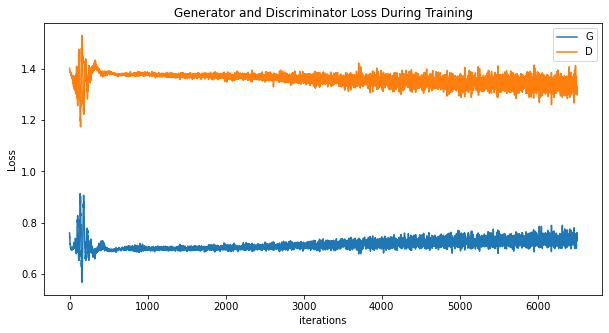

In [22]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

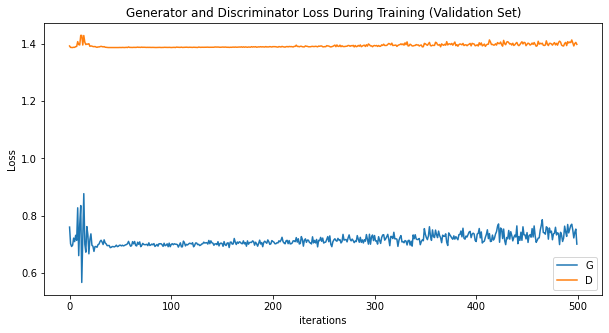

In [23]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training (Validation Set)")
plt.plot(G_losses_val,label="G")
plt.plot(D_losses_val,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

## Train Predictions

In [24]:
train_ops = []
with torch.no_grad():
    for i, data in enumerate(train_set, 0):
        b_size = data[0].size(0)
        noise = torch.randn(b_size, nz, device=device)
        # Generate fake image batch with G
        gen_ip = torch.hstack((data[0],noise)).to(device)
        fake = netG(gen_ip)
        
        train_ops.append(
            (data[1].detach().cpu().numpy(), fake.detach().cpu().numpy())
        )

In [25]:
train_reals = np.concatenate(list(x[0] for x in train_ops))
train_preds = np.concatenate(list(x[1] for x in train_ops))

In [26]:
df_results_train = pd.DataFrame(
    data = np.hstack((
    np.expand_dims(train_reals,1),train_preds
    ))
    ,columns = ["true","pred"]
)

df_results_train.describe()

,true,pred
count,802.000000,802.000000
mean,-0.020810,-0.082995
std,1.001404,0.984552
min,-1.003182,-1.036240
25%,-0.720720,-0.739461
50%,-0.352065,-0.396058
75%,0.210536,0.040195
max,4.170104,3.923240


In [27]:
df_results_train["pred_segment"] = pd.qcut(df_results_train["pred"],10)
df_results_train.groupby("pred_segment").mean()

,true,pred
pred_segment,,
"(-1.037, -0.903]",-0.850243,-0.957360
"(-0.903, -0.784]",-0.780425,-0.847238
"(-0.784, -0.697]",-0.570747,-0.740605
"(-0.697, -0.548]",-0.541099,-0.624556
"(-0.548, -0.396]",-0.376725,-0.470750
"(-0.396, -0.232]",-0.149468,-0.315694
"(-0.232, -0.0639]",-0.041278,-0.156962
"(-0.0639, 0.314]",0.113078,0.064997
"(0.314, 1.547]",0.677998,0.785996


In [28]:
mean_squared_error(df_results_train["true"], df_results_train["pred"]), df_results_train["true"].var()

(0.19895369, 1.0028106)

In [29]:
mean_absolute_error(df_results_train["true"], df_results_train["pred"]), (
    df_results_train["true"]-df_results_train["true"].mean()
).abs().mean()

(0.1753465, 0.7431162)

## Test Predictions

In [30]:
test_ops = []
with torch.no_grad():
    for i, data in enumerate(test_set, 0):
        b_size = data[0].size(0)
        noise = torch.randn(b_size, nz, device=device)
        # Generate fake image batch with G
        gen_ip = torch.hstack((data[0],noise)).to(device)
        fake = netG(gen_ip)
        
        test_ops.append(
            (data[1].detach().cpu().numpy(), fake.detach().cpu().numpy())
        )

In [31]:
test_reals = np.concatenate(list(x[0] for x in test_ops))
test_preds = np.concatenate(list(x[1] for x in test_ops))

In [32]:
df_results = pd.DataFrame(
    data = np.hstack((
    np.expand_dims(test_reals,1),test_preds
    ))
    ,columns = ["true","pred"]
)

df_results.describe()

,true,pred
count,268.000000,268.000000
mean,0.065439,-0.037103
std,1.002904,0.973869
min,-1.002387,-1.018608
25%,-0.614853,-0.689516
50%,-0.259343,-0.313472
75%,0.461146,0.098429
max,3.457055,3.401716


In [33]:
df_results["pred_segment"] = pd.qcut(df_results["pred"],10)
df_results.groupby("pred_segment").mean()

,true,pred
pred_segment,,
"(-1.0199999999999998, -0.915]",-0.880072,-0.957843
"(-0.915, -0.756]",-0.565110,-0.840620
"(-0.756, -0.612]",-0.480056,-0.687709
"(-0.612, -0.452]",-0.536968,-0.543074
"(-0.452, -0.313]",-0.247176,-0.384443
"(-0.313, -0.197]",-0.166662,-0.257862
"(-0.197, -0.0137]",-0.046701,-0.114399
"(-0.0137, 0.444]",0.294141,0.150790
"(0.444, 1.404]",0.952261,0.870660


In [34]:
mean_squared_error(df_results["true"], df_results["pred"]), df_results["true"].var()

(0.18864438, 1.0058161)

In [35]:
mean_absolute_error(df_results["true"], df_results["pred"]), (
    df_results["true"]-df_results["true"].mean()
).abs().mean()

(0.18828678, 0.77412707)

## Test Predictions (averaged)

In [36]:
N_SAMPLES = 100
test_ops = []
with torch.no_grad():
    for i, data in enumerate(test_set, 0):
        b_size = data[0].size(0)
        fakes = []
        for _ in range(N_SAMPLES):
            noise = torch.randn(b_size, nz, device=device)
            # Generate fake image batch with G
            gen_ip = torch.hstack((data[0],noise)).to(device)
            fake = netG(gen_ip).detach().cpu().numpy()
            fakes.append(fake)

        test_ops.append(
            (data[1].detach().cpu().numpy(), sum(fakes)/len(fakes))
        )
# print(test_reals.shape,np.concatenate(list(x[0] for x in test_ops)).shape)
# print(test_preds.shape,np.concatenate(list(x[1] for x in test_ops)).shape)
test_reals = np.concatenate(list(x[0] for x in test_ops))
test_preds = np.concatenate(list(x[1] for x in test_ops))


In [37]:
df_results = pd.DataFrame(
    data = np.hstack((
    np.expand_dims(test_reals,1),test_preds
    ))
    ,columns = ["true","pred"]
)

df_results.describe()

,true,pred
count,268.000000,268.000000
mean,0.065439,-0.032437
std,1.002904,0.959410
min,-1.002387,-0.994835
25%,-0.614853,-0.663623
50%,-0.259343,-0.288634
75%,0.461146,0.093270
max,3.457055,3.227769


In [38]:
df_results["pred_segment"] = pd.qcut(df_results["pred"],10)
df_results.groupby("pred_segment").mean()

,true,pred
pred_segment,,
"(-0.996, -0.883]",-0.880679,-0.932076
"(-0.883, -0.744]",-0.635845,-0.816908
"(-0.744, -0.582]",-0.429325,-0.663846
"(-0.582, -0.446]",-0.484700,-0.526313
"(-0.446, -0.289]",-0.270847,-0.365736
"(-0.289, -0.194]",-0.184819,-0.240207
"(-0.194, -0.0201]",-0.130685,-0.112154
"(-0.0201, 0.325]",0.299012,0.100582
"(0.325, 1.565]",1.040371,0.847727


In [39]:
mean_squared_error(df_results["true"], df_results["pred"]), df_results["true"].var()

(0.17171618, 1.0058161)

In [40]:
mean_absolute_error(df_results["true"], df_results["pred"]), (
    df_results["true"]-df_results["true"].mean()
).abs().mean()

(0.1777495, 0.77412707)

# MSE model

### Define ANN Architecture

In [41]:
# Batch size during training
batch_size = 64

# Number of training epochs
num_epochs = 100

# Learning rate for optimizers
lr = 0.0002
# lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# width of the network
network_width = 128

In [42]:
# # create train and test indices
# train, test = train_test_split(list(range(x.shape[0])), test_size=.2)
# train, val = train_test_split(train, test_size=.25)

In [43]:
# # https://gist.github.com/conormm/5b26a08029b900520bcd6fcd1f5712a0
# class PrepareData(torch.utils.data.Dataset):

#     def __init__(self, X, y, scale_X=True):
#         if not torch.is_tensor(X):
#             if scale_X:
#                 X = StandardScaler().fit_transform(X)
#             self.X = torch.from_numpy(X).float()
#         else:
#             self.X = X.float32()
#         if not torch.is_tensor(y):
#             self.y = torch.from_numpy(y).float()
#         else:
#             self.y = y.float32()

#     def __len__(self):
#         return len(self.X)

#     def __getitem__(self, idx):
#         return self.X[idx], self.y[idx]

# ds = PrepareData(x, y=y, scale_X=False)

# train_set = torch.utils.data.DataLoader(ds, batch_size=batch_size,
#                        sampler=SubsetRandomSampler(train))
# val_set = torch.utils.data.DataLoader(ds, batch_size=batch_size,
#                        sampler=SubsetRandomSampler(val))
# test_set = torch.utils.data.DataLoader(ds, batch_size=batch_size,
#                       sampler=SubsetRandomSampler(test))

In [44]:
# Generator Code

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.Linear( n_feats, network_width, bias=True),
            nn.ReLU(True),

            nn.Linear( network_width, network_width, bias=True),
            nn.ReLU(True),

            nn.Linear( network_width, 1, bias=True)

        )

    def forward(self, input):
        return self.main(input)

In [45]:
# Create the generator
netG = Generator(ngpu).to(device)

# Print the model
print(netG)

Generator(
  (main): Sequential(
    (0): Linear(in_features=11, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=128, out_features=1, bias=True)
  )
)


In [46]:
# Initialize MSELoss function
criterion = nn.MSELoss()

# Setup Adam optimizers for G
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [47]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

G_losses_val = []
D_losses_val = []

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(train_set, 0):
        
        b_size = data[0].size(0)

        ############################
        # Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label = data[1]  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netG(data[0]).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()
        
        # Output training stats
        if i % 500 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(train_set),
                     0, errG.item(), 0, 0, D_G_z2))
                
        # Output validation stats
        if i % 100 == 0:
            with torch.no_grad():
                errG_vals = []
                for i, data in enumerate(val_set, 0):
                    b_size = data[0].size(0)
                    output = netG(data[0]).view(-1)

                    label = data[1] # fake labels are real for generator cost
                    errG_val = criterion(output, label)  

                    errG_vals.append(errG_val.item())
            G_losses_val.append(sum(errG_vals)/len(errG_vals))
        
        
        # Save Losses for plotting later
        G_losses.append(errG.item())
      
        iters += 1

Starting Training Loop...
[0/100][0/13]	Loss_D: 0.0000	Loss_G: 0.6009	D(x): 0.0000	D(G(z)): 0.0000 / 0.2056
[1/100][0/13]	Loss_D: 0.0000	Loss_G: 1.0434	D(x): 0.0000	D(G(z)): 0.0000 / 0.0879
[2/100][0/13]	Loss_D: 0.0000	Loss_G: 0.9282	D(x): 0.0000	D(G(z)): 0.0000 / 0.0001
[3/100][0/13]	Loss_D: 0.0000	Loss_G: 0.9116	D(x): 0.0000	D(G(z)): 0.0000 / -0.0496
[4/100][0/13]	Loss_D: 0.0000	Loss_G: 0.6169	D(x): 0.0000	D(G(z)): 0.0000 / -0.0541
[5/100][0/13]	Loss_D: 0.0000	Loss_G: 0.5138	D(x): 0.0000	D(G(z)): 0.0000 / -0.0705
[6/100][0/13]	Loss_D: 0.0000	Loss_G: 0.2629	D(x): 0.0000	D(G(z)): 0.0000 / -0.1386
[7/100][0/13]	Loss_D: 0.0000	Loss_G: 0.5166	D(x): 0.0000	D(G(z)): 0.0000 / 0.0242
[8/100][0/13]	Loss_D: 0.0000	Loss_G: 0.3377	D(x): 0.0000	D(G(z)): 0.0000 / -0.0027
[9/100][0/13]	Loss_D: 0.0000	Loss_G: 0.3594	D(x): 0.0000	D(G(z)): 0.0000 / -0.0294
[10/100][0/13]	Loss_D: 0.0000	Loss_G: 0.2032	D(x): 0.0000	D(G(z)): 0.0000 / 0.0432
[11/100][0/13]	Loss_D: 0.0000	Loss_G: 0.3133	D(x): 0.0000	D(G(z))

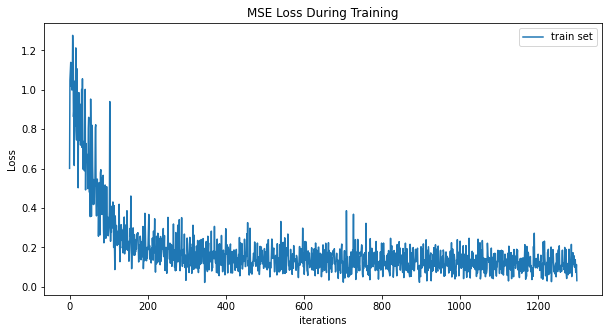

In [48]:
plt.figure(figsize=(10,5))
plt.title("MSE Loss During Training")
plt.plot(G_losses,label="train set")
# plt.plot(G_losses_val,label="val set")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

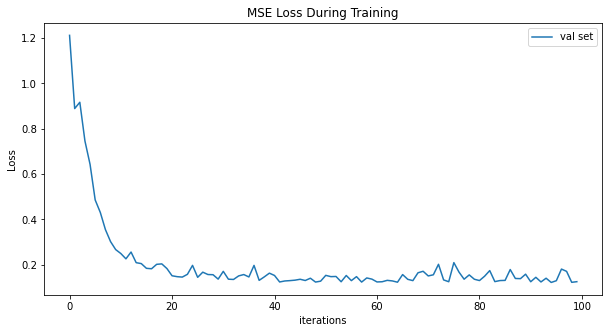

In [49]:
plt.figure(figsize=(10,5))
plt.title("MSE Loss During Training")
# plt.plot(G_losses,label="train set")
plt.plot(G_losses_val,label="val set")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

## Train Predictions

In [50]:
train_ops = []
with torch.no_grad():
    for i, data in enumerate(train_set, 0):
        b_size = data[0].size(0)
        # Generate fake image batch with G
        fake = netG(data[0])
        
        train_ops.append(
            (data[1].detach().cpu().numpy(), fake.detach().cpu().numpy())
        )

In [51]:
train_reals = np.concatenate(list(x[0] for x in train_ops))
train_preds = np.concatenate(list(x[1] for x in train_ops))

In [52]:
df_results_train = pd.DataFrame(
    data = np.hstack((
    np.expand_dims(train_reals,1),train_preds
    ))
    ,columns = ["true","pred"]
)

df_results_train.describe()

,true,pred
count,802.000000,802.000000
mean,-0.020810,-0.077483
std,1.001404,0.934596
min,-1.003182,-1.156649
25%,-0.720720,-0.713318
50%,-0.352065,-0.356225
75%,0.210536,0.043266
max,4.170104,3.454866


In [53]:
df_results_train["pred_segment"] = pd.qcut(df_results_train["pred"],10)
df_results_train.groupby("pred_segment").mean()

,true,pred
pred_segment,,
"(-1.158, -0.864]",-0.892858,-0.945549
"(-0.864, -0.763]",-0.820829,-0.806516
"(-0.763, -0.642]",-0.621765,-0.702325
"(-0.642, -0.509]",-0.495457,-0.581956
"(-0.509, -0.356]",-0.407451,-0.426270
"(-0.356, -0.191]",-0.214631,-0.275976
"(-0.191, -0.0505]",-0.055120,-0.115828
"(-0.0505, 0.21]",0.158147,0.059151
"(0.21, 1.472]",0.746158,0.729615


In [54]:
mean_squared_error(df_results_train["true"], df_results_train["pred"]), df_results_train["true"].var()

(0.11776145, 1.0028106)

In [55]:
mean_absolute_error(df_results_train["true"], df_results_train["pred"]), (
    df_results_train["true"]-df_results_train["true"].mean()
).abs().mean()

(0.17409511, 0.7431162)

## Test Predictions

In [56]:
test_ops = []
with torch.no_grad():
    for i, data in enumerate(test_set, 0):
        b_size = data[0].size(0)
        # Generate fake image batch with G
        gen_ip = data[0] 
        fake = netG(gen_ip)
        
        test_ops.append(
            (data[1].detach().cpu().numpy(), fake.detach().cpu().numpy())
        )

In [57]:
test_reals = np.concatenate(list(x[0] for x in test_ops))
test_preds = np.concatenate(list(x[1] for x in test_ops))

In [58]:
df_results = pd.DataFrame(
    data = np.hstack((
    np.expand_dims(test_reals,1),test_preds
    ))
    ,columns = ["true","pred"]
)

df_results.describe()

,true,pred
count,268.000000,268.000000
mean,0.065439,-0.007660
std,1.002904,0.950514
min,-1.002387,-1.039016
25%,-0.614853,-0.628660
50%,-0.259343,-0.259828
75%,0.461146,0.124640
max,3.457055,3.003042


In [59]:
df_results["pred_segment"] = pd.qcut(df_results["pred"],10)
df_results.groupby("pred_segment").mean()

,true,pred
pred_segment,,
"(-1.0399999999999998, -0.879]",-0.843113,-0.944695
"(-0.879, -0.699]",-0.687708,-0.796087
"(-0.699, -0.577]",-0.429189,-0.632360
"(-0.577, -0.456]",-0.541489,-0.510702
"(-0.456, -0.26]",-0.184978,-0.367509
"(-0.26, -0.142]",-0.101367,-0.196381
"(-0.142, 0.041]",-0.119918,-0.063668
"(0.041, 0.477]",0.243784,0.144923
"(0.477, 1.494]",0.935557,0.959617


In [60]:
mean_squared_error(df_results["true"], df_results["pred"]), df_results["true"].var()

(0.17062266, 1.0058161)

In [61]:
mean_absolute_error(df_results["true"], df_results["pred"]), (
    df_results["true"]-df_results["true"].mean()
).abs().mean()

(0.22311725, 0.77412707)

# Gaussian Process Regression

In [62]:
model = GaussianProcessRegressor(
    kernel=kernels.RBF(length_scale=0.05)
    ,n_restarts_optimizer=10
).fit(x[train], y[train])

In [63]:
model.kernel_.get_params()

{'length_scale': 0.18219515005220469, 'length_scale_bounds': (1e-05, 100000.0)}

In [64]:
y_pred_gauss = model.predict(x[test])
y_true_gauss = y[test]
y_pred_gauss.mean(), y_true_gauss.mean(), y_pred_gauss.std(), y_true_gauss.std()

(-0.04914090985688191,
 0.06543897459142892,
 0.39885401057682995,
 1.0010309920358265)

In [65]:
mean_absolute_error(y_true_gauss, y_pred_gauss), (
    np.abs(
        y_true_gauss-y_true_gauss.mean()
    )
).mean()

(0.6373391160887072, 0.7741270590600026)

In [66]:
mean_squared_error(y_true_gauss, y_pred_gauss), (
    np.abs(
        y_true_gauss-y_true_gauss.mean()
    )**2
).mean()

(0.7929716014469115, 1.0020630470162308)